# Time Series Study

Author: Ömer Adıgüzel

There are two main things we should know about the Time Series Analysis, 
first one is stationary and the second one is the seasonality. We must ensure that our data is stationary (unless we are notworking on a deep learning models like lstm, cnn+lstm etc..) and to know whether we have a seasonality or not.
Here we are given a set of weekly data.

I am going to summarize the study at the beginning and then move to the code.

- Data Exploration
- Data Interpolation by using linear and spline approaches
- ADF and KPSS tests for stationary
- Autocorrelation and PACF(partial autocorrelation) plots
- Stepwise auto arima model building
- State space SARIMAX modelling
- Bonus: Linear Regression Modelling
- Conclusion

Installing Necessary Libraries

In [ ]:
!pip install warnings
!pip install itertools
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install statsmodel
!pip install datetime
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install pyramid-arima

## Data Exploration

In [162]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import scipy.stats as scs
%matplotlib inline

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [163]:
cci = pd.read_csv("RawData.csv", sep = ';')
cci.info()
cci.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
ProductName    52 non-null object
Week           52 non-null object
Price          52 non-null object
SalesQty.      52 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.7+ KB


,ProductName,Week,Price,SalesQty.
47,Product1,2012-26,"2,19",165
48,Product1,2012-27,"2,19",161
49,Product1,2012-28,"2,19",154
50,Product1,2012-29,"2,05",205
51,Product1,2012-30,"1,95",201



Our data has 52 rows, each belong to the mentioned business week.

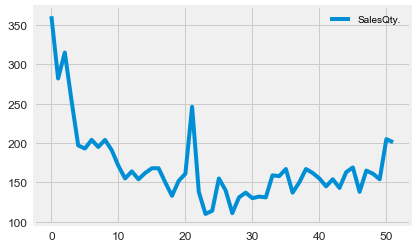

In [164]:
cci.plot()

At first glance, data seems messy, in other words non stationary.
Since our data are weekly based, I decided to interpolated it on daily basis.

In [165]:
# At this step, I am creating a dummy date array
import datetime 
first = datetime.datetime(2011, 8, 1) # date of the Week, 2011-31, starting week of our data
end = datetime.datetime(2012, 7, 23) # date of the Week, 2012-30, ending week of our data
datelist = pd.bdate_range(first, end)

In [166]:
datelist

DatetimeIndex(['2011-08-01', '2011-08-02', '2011-08-03', '2011-08-04',
               '2011-08-05', '2011-08-08', '2011-08-09', '2011-08-10',
               '2011-08-11', '2011-08-12',
               ...
               '2012-07-10', '2012-07-11', '2012-07-12', '2012-07-13',
               '2012-07-16', '2012-07-17', '2012-07-18', '2012-07-19',
               '2012-07-20', '2012-07-23'],
              dtype='datetime64[ns]', length=256, freq='B')

In [167]:
#Here I am extracting the week number of the dates
x = []
for i in range(len(datelist)):
    x.append(datelist[i].isocalendar()[1])
x[1:10]

[31, 31, 31, 31, 32, 32, 32, 32, 32]

At this step, firstly I am creating a dummy data frame, that stores the dates and the calendar week numbers.

In [168]:
import datetime
asd = pd.DataFrame(datelist, x)#.reset_index()
asd['Week'] = asd.index
asd.columns = ['Date', 'Week']

asd = asd.drop_duplicates('Week')
asd['DW'] = asd['Date'].dt.year.map(str) + "-" + asd['Week'].map(str)
asd.columns = ['Date', 'DW', 'Week']
asd['DW'] = asd['DW'].map(str)
asd.head()

,Date,DW,Week
31,2011-08-01,31,2011-31
32,2011-08-08,32,2011-32
33,2011-08-15,33,2011-33
34,2011-08-22,34,2011-34
35,2011-08-29,35,2011-35


So we have a dimension table for our data.

In [169]:
#here fixing some 1 digit concat errors
asd.Week.replace('2012-1', value = '2012-01', inplace=True)
asd.Week.replace('2012-2', value = '2012-02', inplace=True)
asd.Week.replace('2012-3', value = '2012-03', inplace=True)
asd.Week.replace('2012-4', value = '2012-04', inplace=True)
asd.Week.replace('2012-5', value = '2012-05', inplace=True)
asd.Week.replace('2012-6', value = '2012-06', inplace=True)
asd.Week.replace('2012-7', value = '2012-07', inplace=True)
asd.Week.replace('2012-8', value = '2012-08', inplace=True)
asd.Week.replace('2012-9', value = '2012-09', inplace=True)

### Merge our Data Frames

In [170]:
#At this step I am merging my dummy data frame with the original data frame.
merged = pd.merge(asd, cci, how = 'left', on = 'Week')
merged = merged.set_index(merged.Date)
merged = merged['SalesQty.']
merged.head()
# Finally we have our main data with exact dates. Since we are going to forecast SalesQty., I am only having it in my data frame.

Date
2011-08-01    361
2011-08-08    282
2011-08-15    315
2011-08-22    254
2011-08-29    197
Name: SalesQty., dtype: int64

Interpolation is commonly used in time series data, mostly in signal processing. It helps us to fill the unmeasured or missing values.
Here I tried linear and spline(non-linear) interpolation method. And for my study, I used spline interpolated data, even they kinda look similar (check below graph)

<Figure size 432x288 with 0 Axes>

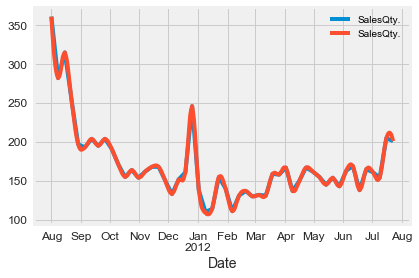

In [171]:
upsampled = merged.resample('D')
interpolated = upsampled.interpolate(method='linear')
interpolated2 = upsampled.interpolate(method='spline', order=2)

polateds = pd.concat([interpolated,interpolated2],axis=1)

plt.figure()
polateds.plot()


I am going to use interpolated2, spline interpolated one.

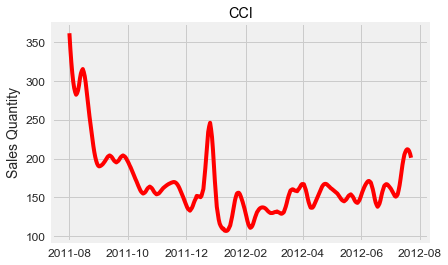

In [172]:
plt.plot(interpolated2.index, interpolated2, 'r')
plt.title('CCI')
plt.ylabel('Sales Quantity');

In [173]:
interpolated2.head(10)
#Now, we have continuous data !

Date
2011-08-01    361.000000
2011-08-02    340.778757
2011-08-03    323.800144
2011-08-04    309.766690
2011-08-05    298.678394
2011-08-06    290.535256
2011-08-07    285.337277
2011-08-08    282.000000
2011-08-09    283.776794
2011-08-10    287.414291
Freq: D, Name: SalesQty., dtype: float64

## Descriptive Statistics of not interpolated data

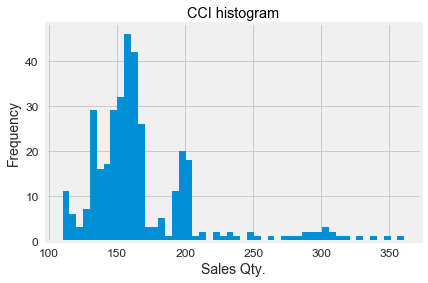

In [174]:
plt.figure()
plt.title("CCI histogram")
plt.xlabel("Sales Qty.")
interpolated.plot(kind="hist", stacked=True, bins=50)

Text(0.5,1,'Month-wise Box Plot\n(The Seasonality)')

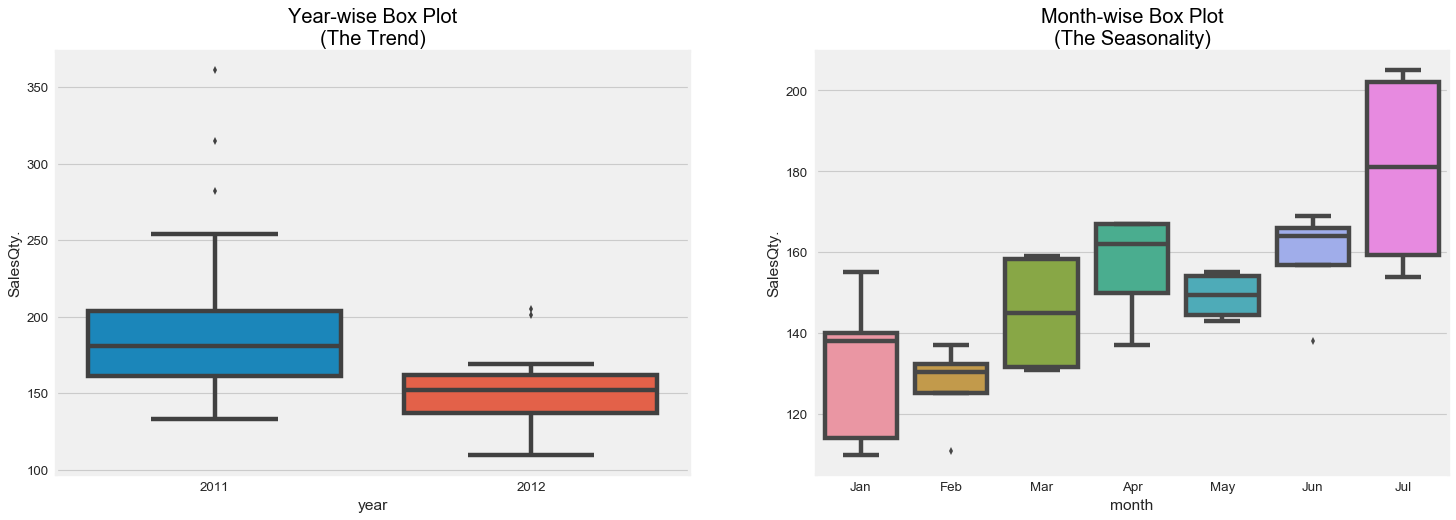

In [175]:
import seaborn as sns # we are going to use seaborn library for dataviz

# Prepare data
dummy = pd.DataFrame(merged) # create a dummy data frame
dummy['DateTime'] = dummy.index

dummy['year'] = [d.year for d in dummy.DateTime]
dummy['month'] = [d.strftime('%b') for d in dummy.DateTime]
years = dummy['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='SalesQty.', data=dummy, ax=axes[0])
sns.boxplot(x='month', y='SalesQty.', data=dummy.loc[~dummy.year.isin([2011, 2013]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)

<b>Comments for above graphs
 - Year-wise Box Plot: In 2011, we have some outlier points, and we proceed to 2012, there is a downward trend in the data.
 
 - Month-wise Box PLot: here the months Jan and Feb are not distributed well, because their median lines is close to the 75% Quartile Range point. Also it can be understood that, no monthly seasonality can be defended by looking at the graph.

## Descriptive Statistics of interpolated data

Text(0.5,1,'Month-wise Box Plot\n(The Seasonality)')

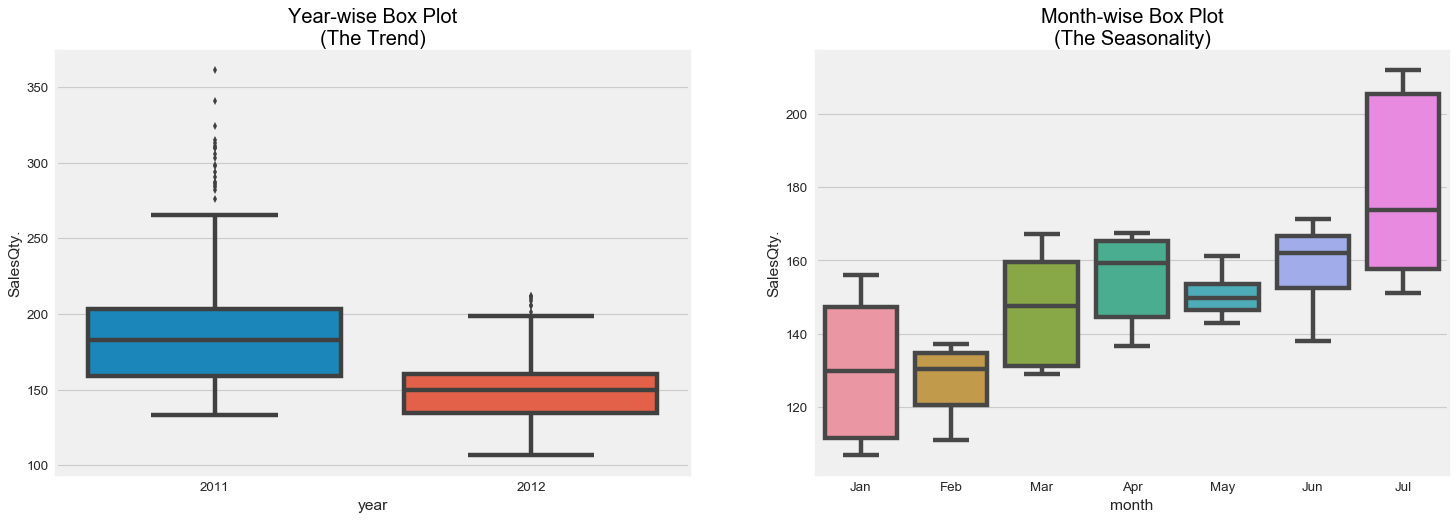

In [176]:
import seaborn as sns
dummy2 = pd.DataFrame(interpolated2)
dummy2['DateTime'] = dummy2.index
# Prepare data
dummy2['year'] = [d.year for d in dummy2.DateTime]
dummy2['month'] = [d.strftime('%b') for d in dummy2.DateTime]
years = dummy2['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='SalesQty.', data=dummy2, ax=axes[0])
sns.boxplot(x='month', y='SalesQty.', data=dummy2.loc[~dummy2.year.isin([2011, 2013]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)

<b>Comments for above graphs
 - Year-wise Box Plot: In 2011, we have more outlier points, and some in 2012.
    
 - Month-wise Box PLot: Jan and Feb are not better distributed than before interpolation. No monthly seasonality can be defended by looking at the graph.

-------------------------------------------------
<b>ADF<b> Test: In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. (wikipedia)
    
KPSS test:

    - Null Hypothesis: the process is trend-stationary
    - Alternative Hypothesis: the process has a unit root (this is how the authors of the test defined the alternative in their original 1992 paper)

ADF test:

    - Null Hypothesis: the process has a unit-root ("difference stationary")
    - Alternative Hypothesis: the process has no unit root. It can mean either that the process is stationary, or trend stationary, depending on which version of the ADF test is used

In [177]:

from statsmodels.tsa.stattools import adfuller, kpss
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# ADF Test
result = adfuller(dummy2['SalesQty.'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(dummy2['SalesQty.'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.2178207042683535
p-value: 8.084660018364765e-06
Critial Values:
   1%, -3.449673193310592
Critial Values:
   5%, -2.8700533746644323
Critial Values:
   10%, -2.5713055939491403

KPSS Statistic: 0.823592
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


As we stated at the beginning of the study, our data is NOT stationary, we just proved it.

Below, a short visualization of the differenced data is given. Differencing method is used to make the Time Series data stationary.
lag 2 at max will be enough, for more lag values, it will not be good for the Time Series data. Non-linear models should be taken into consideration.

----------------------------------------------
<b>To give a quick idea, below the dtrended data is given. The shape of the data looks pretty similar to original data, but the data scale has changed.

Text(0.5,1,'Sales Qty detrended by subtracting the least squares fit')

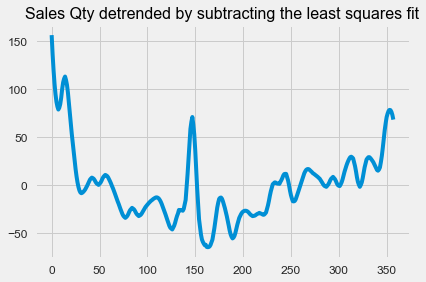

In [178]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(dummy2['SalesQty.'].values)
plt.plot(detrended)
plt.title('Sales Qty detrended by subtracting the least squares fit', fontsize=16)

### Going Deeper

In this part, we are going to check the ACF and PACF functions. Those function plots makes our lives easier when studying Time Series.

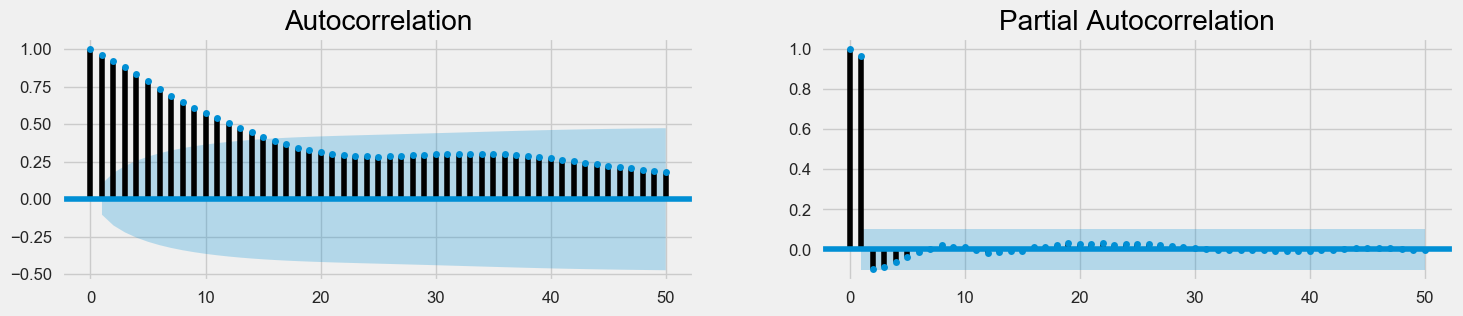

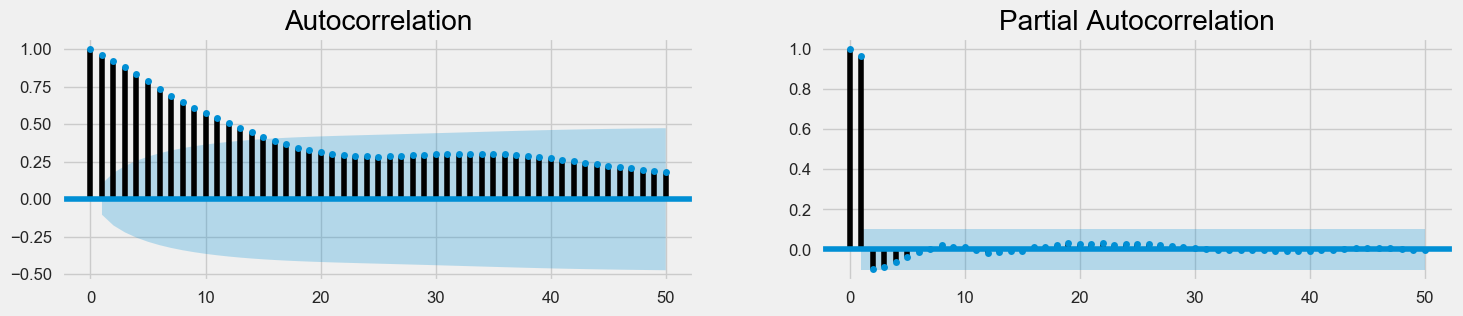

In [179]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(dummy2['SalesQty.'].tolist(), lags=50, ax=axes[0])
plot_pacf(dummy2['SalesQty.'].tolist(), lags=50, ax=axes[1])

<b>Comments:

- We have 2 big spikes at PACF graph and the ACF values are decaying to zero slowly. It means the data is not stationary.
- The 2 big spikes suggests us that, our model should include a degree of 2 AR (auroregressive) component to be included in our model.
- Also we can see that we can not say the seasonality is the subject for our data.

# Modelling

### ARIMA (Auto regressive integrated moving average)

ARIMA, one of the most common method used in Time Series Forecasting.

In [180]:
from pyramid.arima import auto_arima #importing the library for aruto arima forecasting
warnings.filterwarnings("ignore")
"""
here I am defining the degrees of the p,d,q parameter up to 2. Greater than 2 
can be misleading for the model.
Stepwise approach tries all the combinations and gives us the results.
"""
stepwise_model = auto_arima(interpolated2, start_p=1, start_q=1, 
                           max_p=2, max_q=2, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2336.099, BIC=2343.786, Fit time=0.039 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1477.526, BIC=1492.900, Fit time=0.699 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1578.350, BIC=1589.881, Fit time=0.179 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=1438.411, BIC=1457.628, Fit time=2.796 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=2101.220, BIC=2116.595, Fit time=1.816 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=1372.841, BIC=1395.903, Fit time=3.484 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=nan

<b>Comments:<br> After checking the results, we see that:
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=1372.841, BIC=1395.903, Fit time=3.412 seconds
is the best model due to AIC(akaike information criteria)

<b>Splitting our data frame into train and test.

In [181]:
train = interpolated2.loc['2011-01-01':'2012-06-24']
test = interpolated2.loc['2012-06-25':]
print(len(train), len(test))

329 29


<b>We are using our pre-trained model on the splitted train set.

In [182]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

<b>Forecasting our data.

In [183]:
future_forecast = stepwise_model.predict(n_periods=29)

<b>In the graph below, the performance of our forecast is given

<Figure size 432x288 with 0 Axes>

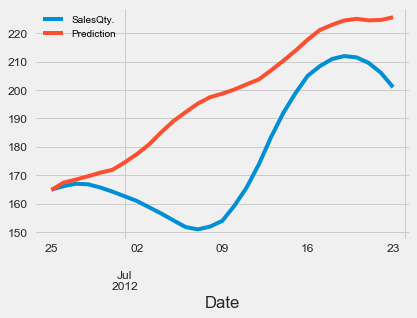

In [184]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
import plotly.plotly
xx = pd.concat([test,future_forecast],axis=1)

plt.figure()
xx.plot()

In [185]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [186]:
print("Mean Absolute Percentage Error: {0:.2f}%".format(mean_absolute_percentage_error(test.values, future_forecast.values)))  

Mean Absolute Percentage Error: 17.93%


<b> Comments:
    - The MAPE is kinda high. So I will try another methods.

## Linear Regression Method

Time Series models also can be also analyzed by regression methods. The AR model is basically an extended version of the regression (least-squares method)

In [187]:
# Creating a copy of the initial datagrame to make various transformations 
datalr = pd.DataFrame(interpolated2.copy())
datalr.columns = ["y"]

In [188]:
# Adding the lag of the target variable from 5 steps back up to 30
for i in range(5, 30):
    datalr["lag_{}".format(i)] = datalr.y.shift(i)

In [189]:
datalr.tail()

,y,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-19,211.945179,191.915422,183.442231,173.890490,165.723370,159.351402,154.000000,151.992920,151.006405,151.815042,...,165.729556,166.871173,167.065411,166.204571,165.000000,161.317660,157.291588,152.210439,146.437252,142.150260
2012-07-20,211.483891,198.899533,191.915422,183.442231,173.890490,165.723370,159.351402,154.000000,151.992920,151.006405,...,164.286745,165.729556,166.871173,167.065411,166.204571,165.000000,161.317660,157.291588,152.210439,146.437252
2012-07-21,209.533524,205.000000,198.899533,191.915422,183.442231,173.890490,165.723370,159.351402,154.000000,151.992920,...,162.650438,164.286745,165.729556,166.871173,167.065411,166.204571,165.000000,161.317660,157.291588,152.210439
2012-07-22,206.094077,208.400515,205.000000,198.899533,191.915422,183.442231,173.890490,165.723370,159.351402,154.000000,...,161.000000,162.650438,164.286745,165.729556,166.871173,167.065411,166.204571,165.000000,161.317660,157.291588
2012-07-23,201.000000,210.917387,208.400515,205.000000,198.899533,191.915422,183.442231,173.890490,165.723370,159.351402,...,158.797336,161.000000,162.650438,164.286745,165.729556,166.871173,167.065411,166.204571,165.000000,161.317660


When you checked the table datalr above, you can easily behave it like a linear regression problem. Lag values are the independent predictors and y is the dependent variable.

In [190]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [191]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [192]:
y = datalr.dropna().y
X = datalr.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
print(len(X_train), len(X_test), len(datalr))

230 99 358


<b> Perfect ! we created our test and train sets.

In [193]:
# Building our model
# pretty fast and simple !
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [194]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test) # prediction on test values
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        #95% Confidence Interval is shown
        scale = 1.96 
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies: # the anomalies is also shown
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

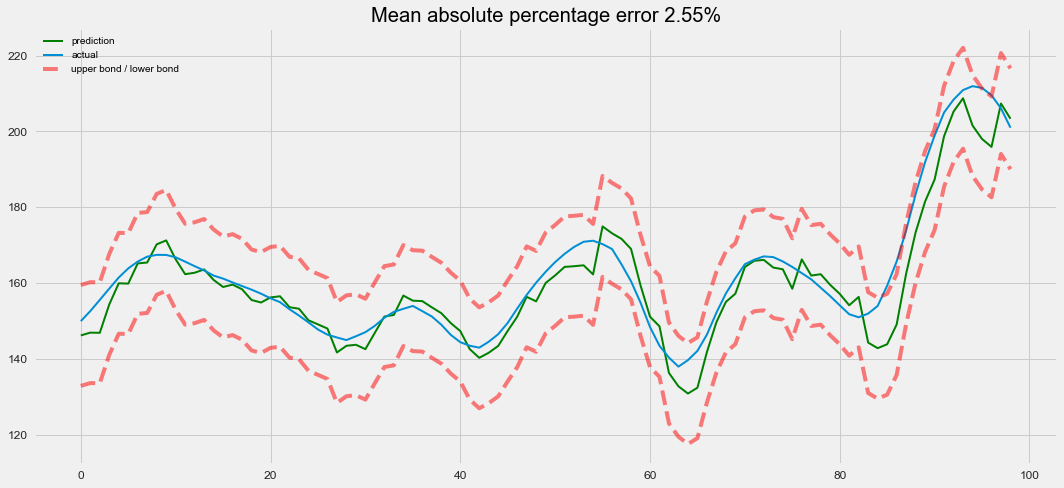

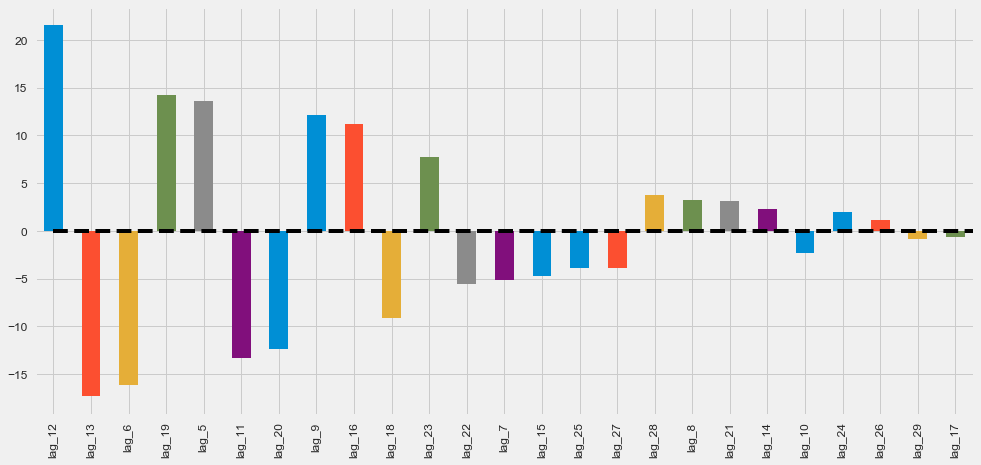

In [195]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

<b> The result of our linear regression looks pretty good ! MAPE is 2.55% much more better then the stepwise arima model !

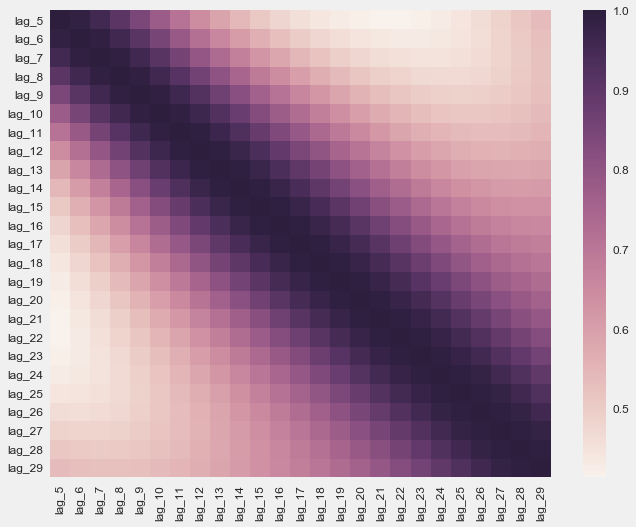

In [196]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

<b> Correlation is really important in regression. while building the model, highly correlated variables should be extracted from the data, since the main assumption is that the predictiors are iid(identically independently distributed). In this study, I am not going perform extraction process.

In [197]:
#To predict via our linear regression model we simply write the code as following:
#coef_ : are the coefficients, also shown in the graph above.
#intercept_: is the intercept of the regression equation.
(sum(lr.coef_ * interpolated2.iloc[-25:]) + lr.intercept_)

169.186092373699

<b> Comments:
    - The linear regression performed very well.
    - The second graph shows the coefficients of the variables.
    
Discussion: Here the overfitting can be a problem, to overcome this, Lasso and Ridge regression methods should be applied.

---------------------------------------------------------
-------------------------------------------------------------
#### Lastly I am going to try SARIMAX and then proceed to results!

---------------------------------------
## Seasonal Autoregressive Integrated Moving-Average with eXogenous regressors (SARIMAX)

<b>What Are State-Space Models?
State-space models are models that use state variables to describe a system by a set of first-order differential or difference equations, rather than by one or more nth-order differential or difference equations. State variables x(t) can be reconstructed from the measured input-output data, but are not themselves measured during an experiment.

In this part, we are going to use SARIMAX to find the best parameters for our Time Series data. It can be named as grid search, that is an indispensible part of the machine learning.

In [198]:
from itertools import product  # some useful functions 
from tqdm import tqdm_notebook # some useful functions

# setting initial values and some bounds for them
# here we are limiting the order of the parameters
ps = range(1, 3) # ar degree of arima
d=1 # difference lag of arima
qs = range(1, 3) # ma degree of arima
Ps = range(0, 2) # ar degree of sarima
D=1 # difference lag of sarima
Qs = range(0, 2) # ma degree of sarima
s = 12 # seasonality

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [199]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(interpolated2, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [200]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [201]:
result_table.head()

,parameters,aic
0,"(2, 2, 0, 0)",1143.202688
1,"(2, 2, 1, 0)",1143.202688
2,"(1, 2, 0, 0)",1279.638212
3,"(1, 2, 1, 0)",1279.638212
4,"(1, 1, 0, 0)",1523.419323


<b> Here AIC(akaike information criteria) helped us to choose the best parameters.

In [202]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(interpolated2, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          SalesQty.   No. Observations:                  358
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                -566.601
Date:                            Tue, 26 Mar 2019   AIC                           1143.203
Time:                                    20:45:04   BIC                           1162.420
Sample:                                08-01-2011   HQIC                          1150.856
                                     - 07-23-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8475      0.012    150.188      0.000       1.823       1.872
ar.L2         -0.9255      0.012   

<b> Residual Plots

Here the important thins are, There should not be a pattern on the distribution of errors, and they should be or close to normal distribution.

- Standardized residual, there is no obvious pattern at the data
- Normal Q-Q, shows that whether the data is normally distributed or not, data points should be on or close to straight line.
- Histogram: shows the distribution they should be around 0 symmetrically
- Correlogram: show the correlations

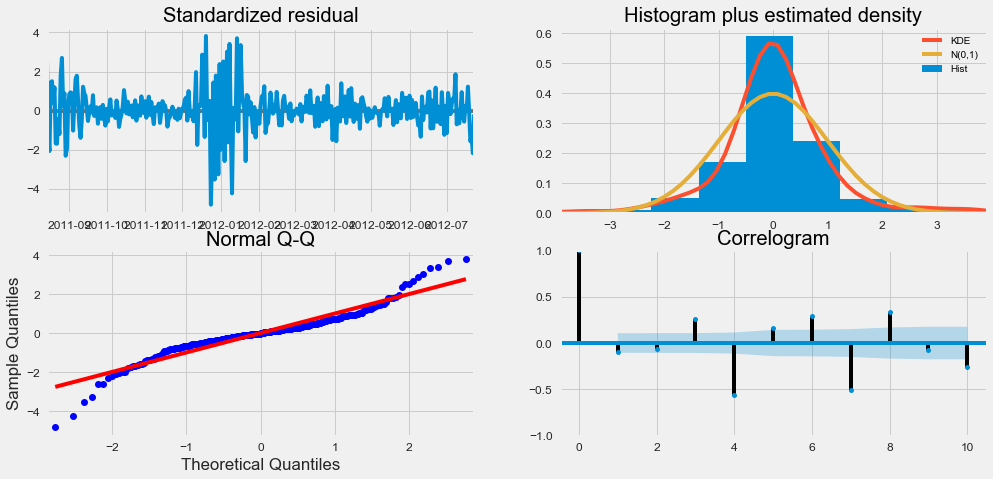

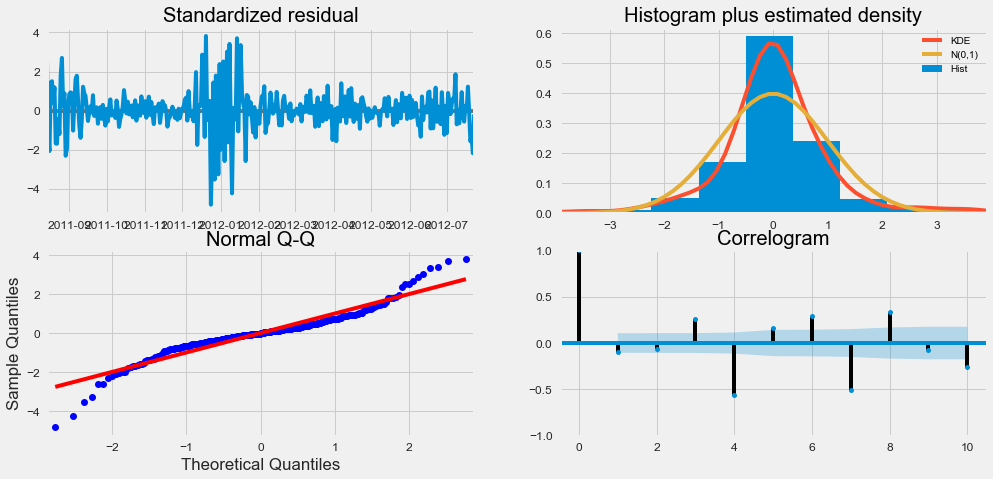

In [203]:
best_model.plot_diagnostics(figsize=(15, 7))

<b> Define a Plot function for the model.

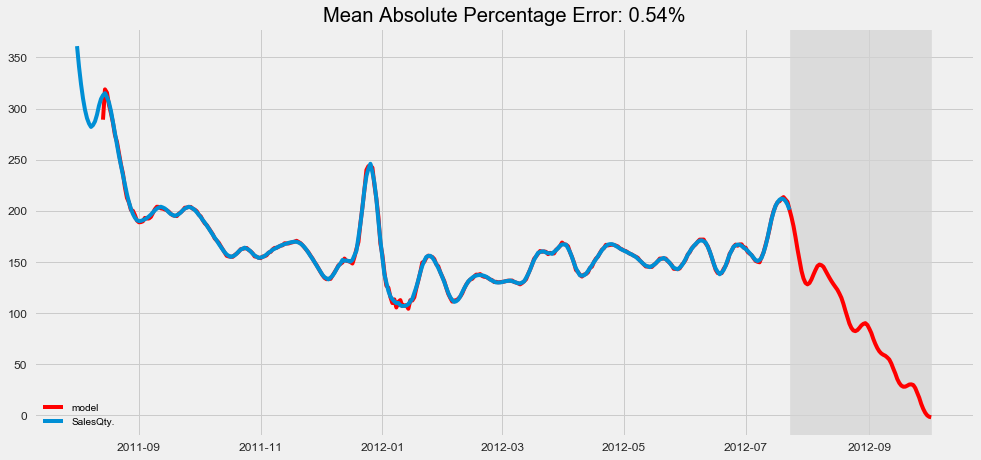

In [204]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data = pd.DataFrame(data)
    data.columns = ['SalesQty.']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['SalesQty.'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.7, color='lightgrey')
    plt.plot(data['SalesQty.'], label="SalesQty.")
    plt.legend()
    plt.grid(True);
    
plotSARIMA(interpolated2, best_model, 70)

<b> Comments:
    - The sarimax model performs pretty good, MAPE: 0.54% much more better than stepwise auto arima

# <b> Building the Submission

In [205]:
data = interpolated2.copy()
data = pd.DataFrame(data)
data.columns = ['SalesQty.']
data['arima_model'] = best_model.fittedvalues
# making a shift on s+d steps, because these values were unobserved by the model
# due to the differentiating
data['arima_model'][:s+d] = np.NaN

# forecasting forward 
forecast = best_model.predict(start = data.shape[0], end = '2012-09-23')
forecast = data.arima_model.append(forecast)

In [206]:
submission = forecast[forecast.index >= '2012-07-30']

In [207]:
submission = pd.DataFrame(submission)
submission['Date'] = submission.index
submission['Date'] = pd.to_datetime(submission['Date'])
submission.columns = ['SalesQty.', 'Date']
submission['Week'] = 0
#submission['Year'] = submission['Date'].dt.year.map(str)
for i in range(len(submission)):
    submission['Week'][i] = submission['Date'][i].isocalendar()[1]
submission['DateTime'] = submission['Date'].dt.year.map(str) + "-" + submission['Week'].map(str)

In [208]:
submission.head(14)

,SalesQty.,Date,Week,DateTime
2012-07-30,133.981093,2012-07-30,31,2012-31
2012-07-31,129.553840,2012-07-31,31,2012-31
2012-08-01,128.140890,2012-08-01,31,2012-31
2012-08-02,129.480903,2012-08-02,31,2012-31
2012-08-03,133.001314,2012-08-03,31,2012-31
2012-08-04,137.720602,2012-08-04,31,2012-31
2012-08-05,142.126657,2012-08-05,31,2012-31
2012-08-06,146.021617,2012-08-06,32,2012-32
2012-08-07,147.524539,2012-08-07,32,2012-32
2012-08-08,146.866144,2012-08-08,32,2012-32


### Here our results finally !

In [209]:
submission.groupby('DateTime').mean()

,SalesQty.,Week
DateTime,,
2012-31,133.429328,31
2012-32,142.859603,32
2012-33,121.629696,33
2012-34,88.985768,34
2012-35,86.735814,35
2012-36,64.506066,36
2012-37,45.214771,37
2012-38,29.309338,38
